# Vivarium Interface Demo

This notebook demonstrates the usage of the Vivarium Python API for building, verifying, and saving composite process-bigraph simulations. It includes examples of initializing a simulation, running it, retrieving results, and generating visual diagrams.

In [1]:
import random
from vivarium import Vivarium
from vivarium.tests import DEMO_PROCESSES  # toy processes

In [2]:
# initialize a Vivarium object
v = Vivarium(processes=DEMO_PROCESSES,
             # require=['units', 'sbml', 'sedml=0.1.0']
             )

In [3]:
# view the available types
v.get_types()

,Type
0,
1,length*temperature
2,integer
3,number
4,current
...,...
90,mass^0_5/length^0_5*time
91,length*mass/current*time^3
92,step
93,luminosity/length^2


In [4]:
# view the type schema for 'string'
v.get_type('length')

,Attribute,Value
0,default,1 dimensionless
1,description,type to represent values with scientific units


In [5]:
# view the available processes
v.get_processes()

,Process
0,increase float
1,ram-emitter
2,composite
3,increase mass
4,console-emitter


In [6]:
# inspect the config schema for the 'increase' process
v.process_schema('increase float')

'(rate:float)'

In [7]:
# # TODO -- this could look better. Maybe get the dataclass so it can be passed back into the process?
# schema = v.process_schema('increase float')
# d = v.core.dataclass(schema)
# d.rate = 0.1
# # d can be passed into the process

In [8]:
# inspect the process interface (inputs/outputs) for the 'increase' process
# TODO -- fix this output. interface might need a config
v.process_interface('increase mass')

,,default,description,Type
Inputs,mass,1.0 gram,type to represent values with scientific units,NaN


In [9]:
# add an increase process called 'increase process'
v.add_process(name='increase',
              process_id='increase float',  # this is the process id
              config={'rate': 0.1},         # set according to the config schema. TODO Could this accept a dataclass?
              )

# print the current state
v

Vivarium( 
{ 'global_time': 0.0,
  'increase': { 'address': 'local:increase float',
                'config': {'rate': 0.1},
                'inputs': {},
                'instance': <vivarium.tests.IncreaseFloat object at 0x10dc00bb0>,
                'interval': 1.0,
                'outputs': {}}})

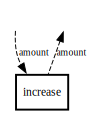

In [10]:
# display as a diagram
v.diagram(dpi='70', remove_nodes=['global_time'])

In [11]:
# connect the 'increase' process to the state through its inputs and outputs
v.connect_process(
    process_name='increase',
    inputs={'amount': ['top', 'A']},
    outputs={'amount': ['top', 'A']}
)

# display the current state
v

Vivarium( 
{ 'global_time': 0.0,
  'increase': { 'address': 'local:increase float',
                'config': {'rate': 0.1},
                'inputs': {'amount': ['top', 'A']},
                'instance': <vivarium.tests.IncreaseFloat object at 0x10dc00bb0>,
                'interval': 1.0,
                'outputs': {'amount': ['top', 'A']}},
  'top': {'A': 1.0}})

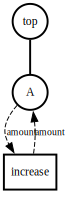

In [12]:
# display the current state as a diagram
v.diagram(dpi='70', remove_nodes=['global_time', 'emitter'])

In [13]:
# get the value of 'top.A'
v.get_value(path=['top', 'A'])

1.0

In [14]:
# set value of 'top.A' to 100
v.set_value(path=['top', 'A'], value=100.0)
v.get_value(path=['top', 'A'])

100.0

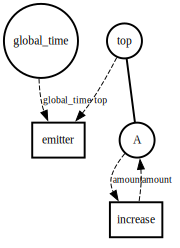

In [15]:
# add an emitter to save the history
# TODO -- improve emitter configurability
v.add_emitter()

# display the current state
v.diagram(dpi='70')

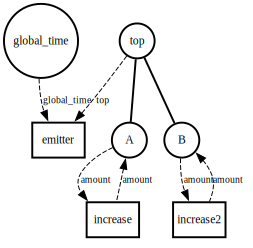

In [16]:
# add more objects
v.add_object(name='B', path=['top'], value=1)

# add another increase process
v.add_process(name='increase2',
              process_id='increase float',
              config={'rate': -0.1},
              inputs={'amount': ['top', 'B']},
              outputs={'amount': ['top', 'B']}
              )

# display the current state
v.diagram(dpi='70', size='30,15')

In [17]:
# run the simulation for 10 time units
v.run(interval=10)

In [18]:
# get the timeseries results
timeseries = v.get_timeseries(significant_digits=6)
timeseries

,/global_time,/top/A,/top/B
0,0.0,100.000000,1.000000
1,1.0,110.000000,0.900000
2,2.0,121.000000,0.810000
3,3.0,133.100000,0.729000
4,4.0,146.410000,0.656100
5,5.0,161.051000,0.590490
6,6.0,177.156100,0.531441
7,7.0,194.871710,0.478297
8,8.0,214.358881,0.430467
9,9.0,235.794769,0.387420


In [19]:
v.plot_timeseries(
    query=None,
    subplot_size=(6, 3),
    ncols=2,
    # combined_vars=None
)

KeyError: 'global_time'

# Save and Load

In [20]:
# save the current state to a file
v.save(filename='demo1')

Saved file: out/demo1.json


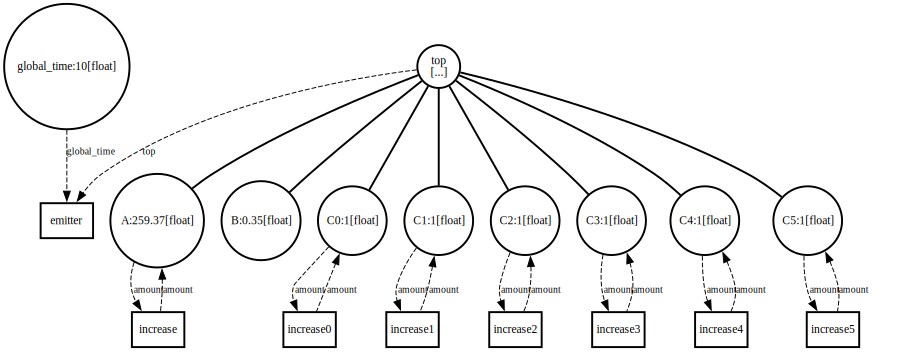

In [21]:
# make a new Vivarium object (v2) from the saved file
v2 = Vivarium(document='out/demo1.json', processes=DEMO_PROCESSES)

n_new_nodes = 6

# add another object and process
for i in range(n_new_nodes):
    v2.add_object(name=f'C{i}', path=['top'], value=1)
    v2.add_process(name=f'increase{i}',
                   process_id='increase float',
                   config={'rate': random.uniform(-1, 1)},
                   inputs={'amount': ['top', f'C{i}']},
                   outputs={'amount': ['top', f'C{i}']}
                   )

# display the current state as a diagram
v2.diagram(dpi='70',
           show_values=True,
           show_types=True,
           )

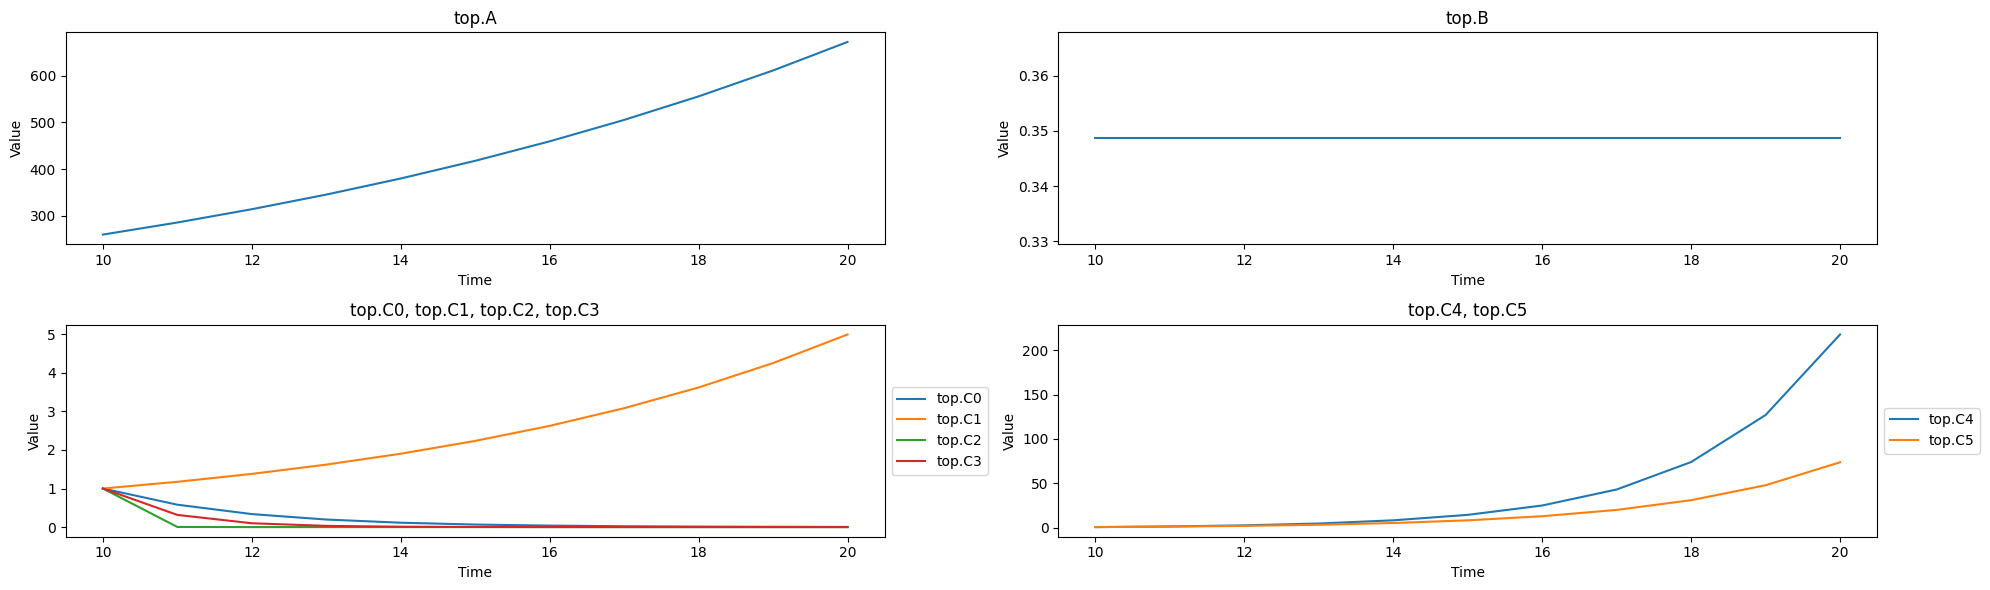

In [22]:
v2.run(interval=10)
v2.plot_timeseries(subplot_size=(10, 3),
                   ncols=2,
                   combined_vars=[[f'top.C{i}' for i in range(4)],
                                  [f'top.C{i}' for i in range(4, n_new_nodes)]])

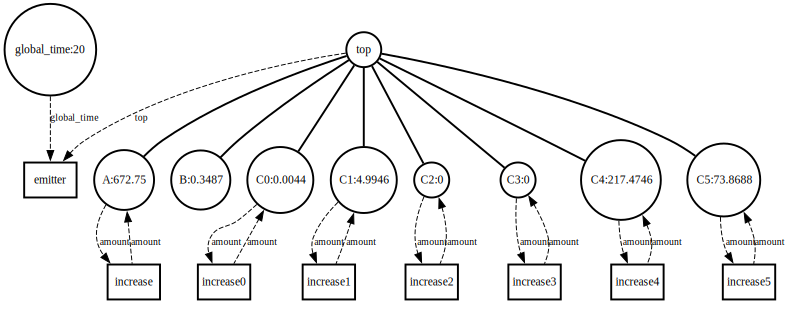

In [23]:
v2.diagram(dpi='70',
           show_values=True,
           # show_types=True,
           significant_digits=4,
           )

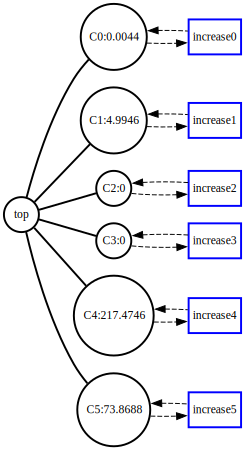

In [24]:
v2.diagram(dpi='70',
           show_values=True,
           # show_types=True,
           significant_digits=4,
           rankdir='LR',
           port_labels=False,
           remove_nodes=['top.A', 'top.B', 'increase', 'emitter', 'global_time'],
           node_border_colors={(f'increase{i}',): 'blue' for i in range(n_new_nodes)},
           )